# Comparing two samples using `stambo`

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Oulu-IMEDS/stambo/main?labpath=notebooks%2FTwo_sample_test.ipynb)

V1.1.5: © Aleksei Tiulpin, PhD, 2025

There are many cases, when we develop models other than classification or regression, and we want to compute scores per datapoint, and then find their mean. We may often want to compare just two samples of measurements, and `stambo` allows to do this easily too.

This example shows how to conduct a simple two-sample test. The example is synthetic, and we will just simply generate two Gaussian samples, and assess whether the mean of the second sample is greater than the mean of the first sample.

## Importing the libraries

In [1]:
import numpy as np
import stambo
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

SEED=2025

stambo.__version__

'0.1.5'

## Data generation

In [2]:
np.random.seed(SEED)
n_samples = 50
sample_1 = np.random.randn(n_samples)
sample_2 = np.random.randn(n_samples)+0.7 # effect size is 0.7

## Sample comparison

Note that when it comes to a two-sample test, `stambo` does not require the statistic of choice to be a machine learning metric that is a subclass of `stambo.metrics.Metric`.
Note that we have a non-paired design here (a regular two-sample test), so, it needs to be specified.

In [3]:
res = stambo.two_sample_test(sample_1, sample_2, statistics={"Mean": lambda x: x.mean()}, non_paired=True)

Bootstrapping:   0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
res

{'Mean': array([ 0.1039792 ,  0.23771615, -0.11272705,  0.58867682,  0.08127468,
        -0.17035326,  0.34184593,  0.31899082,  0.07648143,  0.56946271])}

## LaTeX report

In [5]:
print(stambo.to_latex(res, m1_name="Control", m2_name="Treated"))

% \usepackage{booktabs} <-- do not forget to have this imported. 
\begin{tabular}{ll} \\ 
\toprule 
\textbf{Model} & \textbf{Mean} \\ 
\midrule 
Control & $0.08$ [$-0.17$-$0.34$] \\ 
Treated & $0.32$ [$0.08$-$0.57$] \\ 
\midrule
Effect size & $0.24$ [$-0.11$-$0.59]$ \\ 
\midrule
$p$-value & $0.10$ \\ 
\bottomrule
\end{tabular}


This example shows that for the data at hand we did not have samples to reject the null. 

## Grouped data

A very common scenario we should consider is when data is grouped (or clustered). For example, we have multiple datapoints from the same subjects. 

Below is the simulation code that generates synthetic data for case when we have multiple datapoints from the same subject. To see if your data is grouped, you can plot a covaraince matrix of your data. 

Generated data with shape: X=(800, 4), y=(800,)
Structure: 40 blocks of size 18


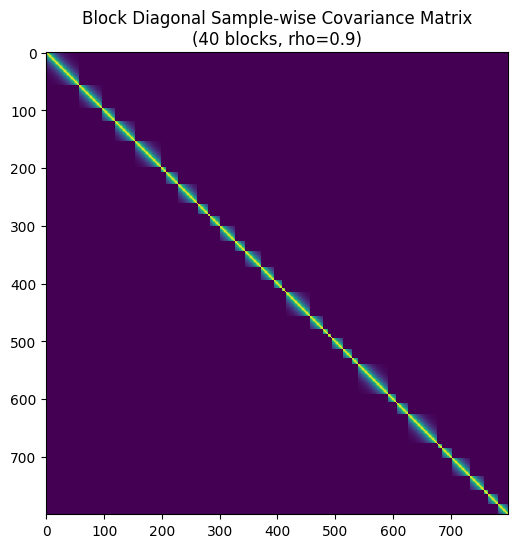

In [6]:
def generate_covariance(size, rho, sigma=1.0):
    """
    Generates an AR(1) covariance matrix for a single block.
    Formula: Cov(i, j) = sigma^2 * rho^|i-j|
    """
    indices = np.arange(size)
    # Calculate |i - j| matrix
    diff = np.abs(np.subtract.outer(indices, indices))
    # Apply AR(1) formula
    cov_matrix = (sigma**2) * (rho**diff)
    return cov_matrix

# --- Settings ---
n_groups = 40          # Number of independent blocks
N = 800
p = 4                 # Number of predictors (features)
rho = 0.9             # Correlation strength within blocks (0 to 1)
noise_sigma = 1.0    # Standard deviation of noise

# --- 1. Generate Predictors (X) and True Coefficients (Beta) ---
np.random.seed(42)
X = np.random.normal(0, 1, size=(N, p))
beta = np.array([2.5, -1.0, 3.2, 0.5])


if N < n_groups:
    raise ValueError("N must be greater or equal to the number of groups")

base = np.ones(n_groups, dtype=int)
remaining = N - n_groups

probs = np.random.dirichlet(np.ones(n_groups) * 0.9)
extra = np.random.multinomial(remaining, probs)
counts = base + extra

# Sanity check to ensure we can safely combine with X
assert counts.sum() == N, "Block sampling must result in exactly N samples"

group_errors_1 = []
group_errors_2 = []
block_covariances = [] # Storing these just to visualize later

subject_ids = []
for i in range(n_groups):
    # Create covariance for this specific block
    group_size = counts[i]
    subject_ids.extend([i] * group_size)
    sigma_block = generate_covariance(group_size, rho, noise_sigma)
    block_covariances.append(sigma_block)
    
    # Sample noise for this block: epsilon ~ N(0, Sigma_block)
    # We use Cholesky decomposition for sampling: L * standard_normal
    L = np.linalg.cholesky(sigma_block)
    u = np.random.normal(0, 1, size=group_size)
    e_block_1 = L @ u

    u = np.random.normal(0, 1, size=group_size)
    e_block_2 = L @ u
    
    
    group_errors_1.append(e_block_1)
    group_errors_2.append(e_block_2)

# Concatenate all block errors to create the full epsilon vector
epsilon_1 = np.concatenate(group_errors_1)
epsilon_2 = np.concatenate(group_errors_2)

# --- 3. Generate Target Variable (y) ---
# Here we set no difference (NULL is true)
group_1 = X @ beta + epsilon_1
group_2 = X @ beta + epsilon_2

if group_1.mean() > group_2.mean():
    group_1, group_2 = group_2, group_1

print(f"Generated data with shape: X={X.shape}, y={group_1.shape}")
print(f"Structure: {n_groups} blocks of size {group_size}")

# --- Optional: Visualize the Full Covariance Matrix ---
# Construct full matrix just for visualization
Sigma_full = block_diag(*block_covariances)

plt.figure(figsize=(6, 6))
plt.imshow(Sigma_full, cmap='viridis', interpolation='none')
#plt.colorbar(label='Covariance')
plt.title(f"Block Diagonal Sample-wise Covariance Matrix\n({n_groups} blocks, rho={rho})")
plt.show()

## Grouped data & paired design

Let us now cover another common case: we have a number of subjects with multiple measurements taken before and after treatment. We want to estimat the treatment effect, or rather - confidence intervals on it. 
This case is highly related to comparing two models. Model 1 could be seen as control, and improvements done on it (Model 2) could be seen as treatment. 

We now utilize our earlier generated data from the clustered design.

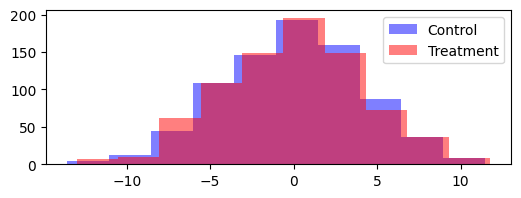

In [7]:
plt.figure(figsize=(6, 2))
plt.hist(group_1, label="Control", color="blue", alpha=0.5)
plt.hist(group_2, label="Treatment", color="red", alpha=0.5)
plt.legend()
plt.show()


Let us now first run the test without specifying the groups. 

In [8]:
res = stambo.two_sample_test(group_1, group_2, statistics={"Mean": lambda x: x.mean()}, seed=SEED)
print(stambo.to_latex(res, m1_name="Control", m2_name="Treatment"))

Bootstrapping:   0%|          | 0/5000 [00:00<?, ?it/s]

% \usepackage{booktabs} <-- do not forget to have this imported. 
\begin{tabular}{ll} \\ 
\toprule 
\textbf{Model} & \textbf{Mean} \\ 
\midrule 
Control & $-0.08$ [$-0.37$-$0.21$] \\ 
Treatment & $0.05$ [$-0.24$-$0.35$] \\ 
\midrule
Effect size & $0.13$ [$0.04$-$0.23]$ \\ 
\midrule
$p$-value & $0.00$ \\ 
\bottomrule
\end{tabular}


What we can se above, is that the test detects an effect where thereis actually no effect 

In [9]:
res = stambo.two_sample_test(group_1, group_2, statistics={"Mean": lambda x: x.mean()}, groups=subject_ids, seed=SEED)
# Let us add more digits to see the p-value clearer
print(stambo.to_latex(res, m1_name="Control", m2_name="Treatment", n_digits=4))

Bootstrapping:   0%|          | 0/5000 [00:00<?, ?it/s]

% \usepackage{booktabs} <-- do not forget to have this imported. 
\begin{tabular}{ll} \\ 
\toprule 
\textbf{Model} & \textbf{Mean} \\ 
\midrule 
Control & $-0.0780$ [$-0.4026$-$0.2338$] \\ 
Treatment & $0.0543$ [$-0.2731$-$0.3990$] \\ 
\midrule
Effect size & $0.1323$ [$-0.1588$-$0.4641]$ \\ 
\midrule
$p$-value & $0.2056$ \\ 
\bottomrule
\end{tabular}


Once we have specified the groups, we get very tight 95% CIs around the true effect (0.5), showing that it is really positive. Moreover, we are able to reject the null, since our bootstrap procedure closely resembles the data generating process. 